<a href="https://colab.research.google.com/github/sxergiu/fac-year-3/blob/main/IPR/IPR_Laboratory_Test_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Lab 1

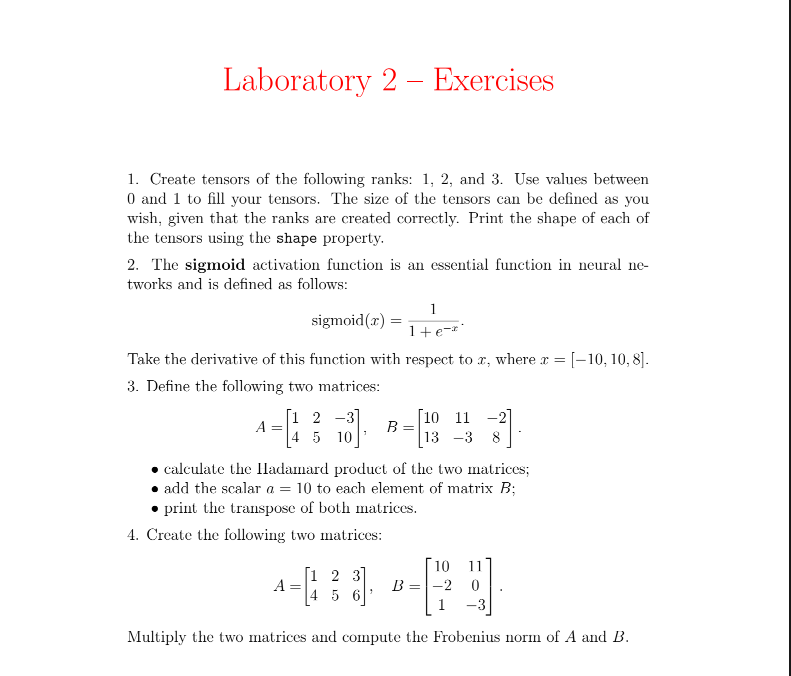

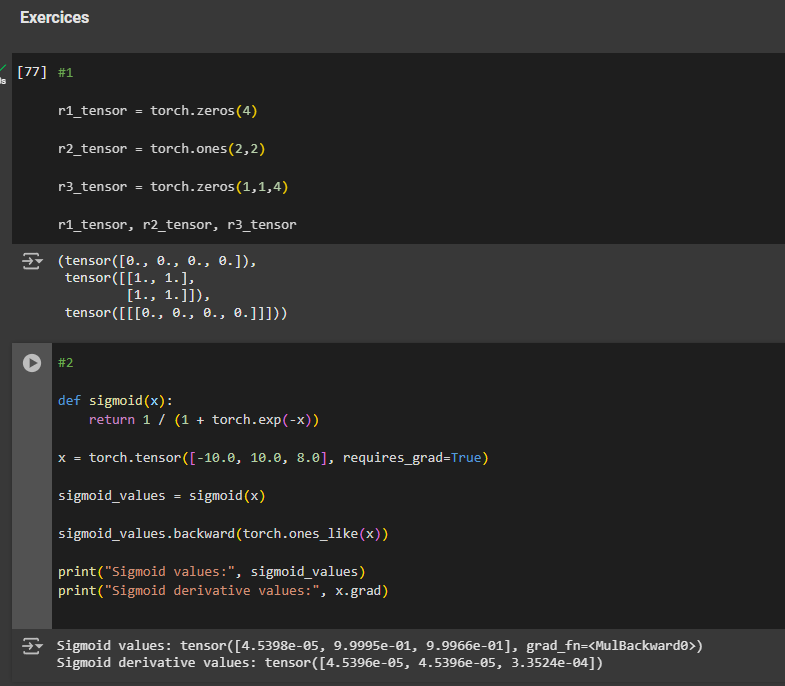

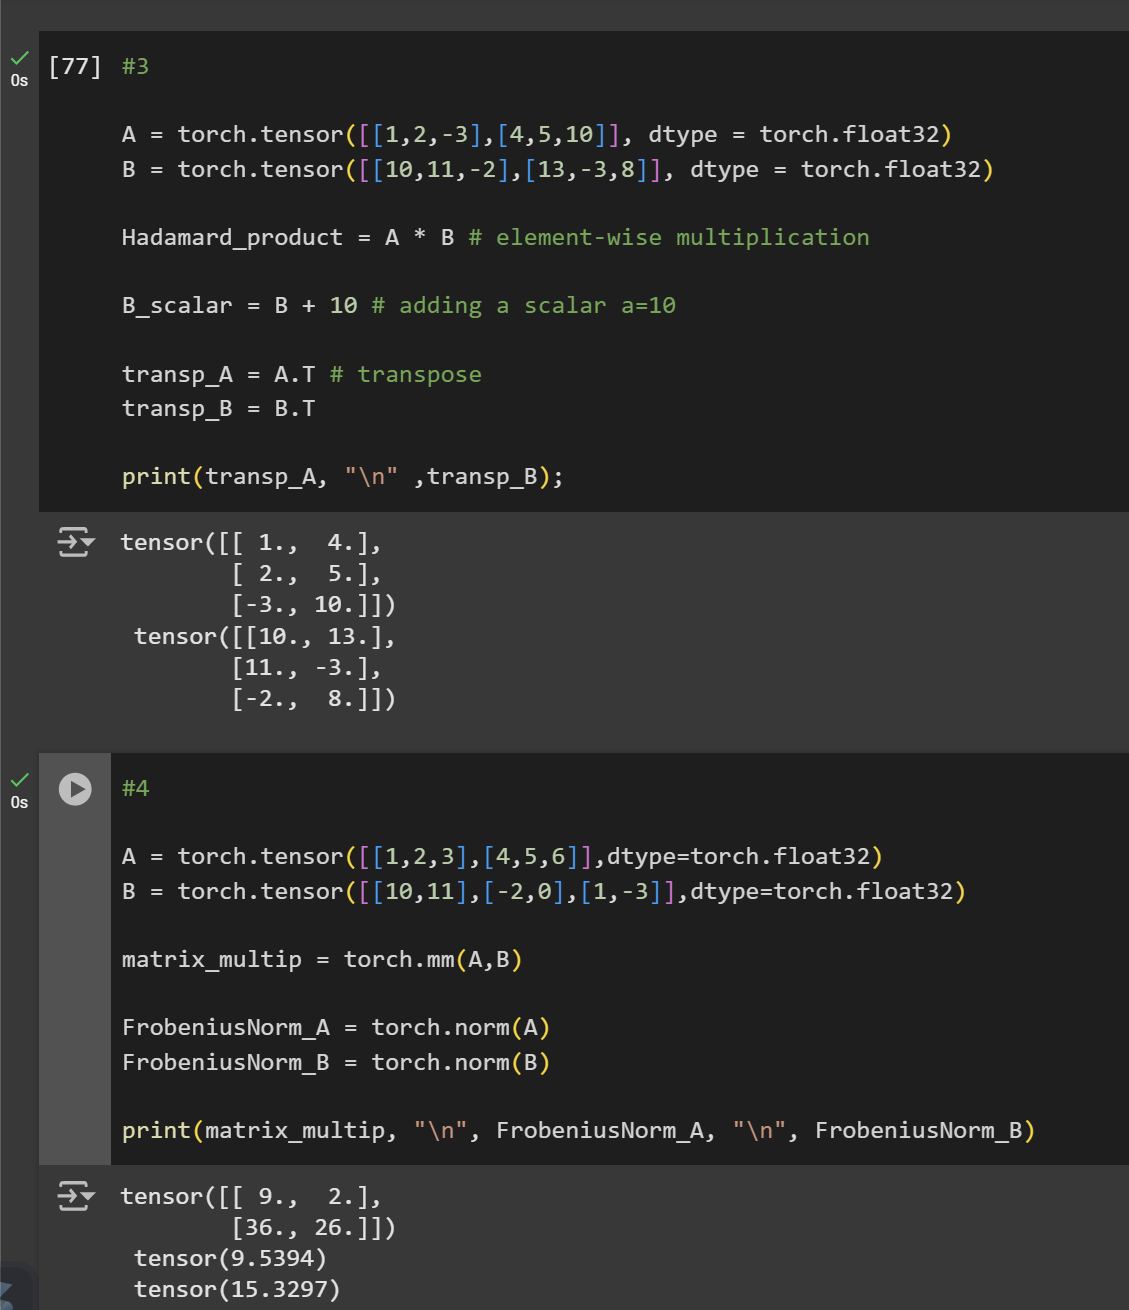